# Generate river boundary from Mass1 simulation

In [10]:
library("xts")
library("signal")


Attaching package: ‘signal’

The following objects are masked from ‘package:stats’:

    filter, poly



## I/O files

In [5]:
imodel=c("100x100x2_6h_bc")

model_dir = "/global/project/projectdirs/m1800/pin/Reach_scale_model/"
# mass1 data
fname_mass1_coord = paste(model_dir, "data/MASS1/coordinates.csv", sep = "")
fname_mass1_pts = paste(model_dir, "data/MASS1/transient_1976_2016/", sep = "")

fname_mass1_xts = paste(model_dir, "results/mass.data.xts.r", sep = "")
fname_mass1_data.r = paste(model_dir, "results/mass.data.r", sep = "")

fname_model_inputs.r = paste(model_dir, "results/HFR_model_100x100x2_6h_bc/model_inputs.r", sep = "")

is.smooth = T

fname_DatumH = paste(model_dir, "Inputs/river_bc/bc_7d_smooth_032807/DatumH_Mass1_", sep = "")
fname_Gradients = paste(model_dir, "Inputs/river_bc/bc_7d_smooth_032807/Gradients_Mass1_", sep = "")

In [6]:
load(fname_model_inputs.r)

In [3]:
model_origin = c(551600, 104500)

start.time = as.POSIXct("2007-03-28 12:00:00",tz="GMT",format="%Y-%m-%d %H:%M:%S")
#start.time = as.POSIXct("2007-01-01 00:00:00",tz="GMT",format="%Y-%m-%d %H:%M:%S")
end.time = as.POSIXct("2016-01-01 00:00:00",tz="GMT",format="%Y-%m-%d %H:%M:%S")

mass.coord = read.csv(fname_mass1_coord)
mass.coord[,"easting"] = mass.coord[,"easting"]-model_origin[1]
mass.coord[,"northing"] = mass.coord[,"northing"]-model_origin[2]

## compile all MASS1 data

In [4]:
attach(fname_mass1_xts, pos = 2)

In [5]:
##------------------------- compile all the mass1 data --------------------------
if (!file.exists(fname_mass1_xts)) {
  
  slice.list = as.character(mass.coord[,1])
  
mass.data = list()
for (islice in slice.list) {
  print(islice)
  mass.data[[islice]] = read.csv(paste(fname_mass1_pts,"mass1_",
                                       islice,".csv",sep=""))
}
names(mass.data) = slice.list

for (islice in slice.list) {
  print(islice)
  mass.data[[islice]][["date"]] =
    as.POSIXct(mass.data[[islice]][["date"]],format="%Y-%m-%d %H:%M:%S",tz='GMT')
  mass.data[[islice]][["stage"]] = mass.data[[islice]][["stage"]]+1.039
}


# save(mass.data, file=fname_mass1_data.r)

# time.index = seq(from=start.time,to=end.time,by="1 hour")
# ntime = length(time.index)
# simu.time = c(1:ntime-1)*3600

mass.data.xts = list()
for (islice in slice.list)
{
  print(islice)
  mass.data.xts[[islice]] = xts(mass.data[[islice]],
                                order.by=mass.data[[islice]][["date"]] ,unique=T,tz="GMT")
  
  mass.data.xts[[islice]] = mass.data.xts[[islice]][
    .indexmin(mass.data.xts[[islice]][,"date"]) %in% c(56:59,0:5)]

  index(mass.data.xts[[islice]]) = round(index(mass.data.xts[[islice]]),units="hours")
  mass.data.xts[[islice]] = mass.data.xts[[islice]][
    !duplicated(.index(mass.data.xts[[islice]]))]
  mass.data.xts[[islice]] = merge(mass.data.xts[[islice]],time.index)
  
}

save(mass.data.xts,file=paste(results.dir,"mass.data.xts.r",sep=""))
} else {
    
  load(fname_mass1_xts)
  print("mass1_xts loaded.")
}

# generate river bc

In [51]:
##------------------------- generate river bc-----------------------------------
slice.list = names(mass.data.xts)
# slice.list = c("40", "41")
# islice = slice.list
nslice = length(slice.list)


for (islice in slice.list)
{
    mass.data.xts[[islice]] = mass.data.xts[[islice]][index(mass.data.xts[[islice]])>=start.time,]
    mass.data.xts[[islice]] = mass.data.xts[[islice]][index(mass.data.xts[[islice]])<=end.time,]    
}


time.index = seq(from=start.time,to=end.time,by="1 hour")
ntime = length(time.index)
simu.time = c(1:ntime-1)*3600

In [51]:
mass.gradient = rep(NA,ntime)
mass.level = array(NA,c(nslice,ntime))
rownames(mass.level) = slice.list
for (islice in slice.list) {
    mass.level[islice,] = mass.data.xts[[islice]][,"stage"]
}
available.date = which(colSums(mass.level,na.rm=TRUE)>200)

## smooth using moving average 

In [52]:
# nwindows = 6 #hour
# nwindows = 24*1 #1d
nwindows = 24*7 #1 week
dt = 3600
filt = Ma(rep(1/nwindows,nwindows))
# new.mass.level = array(NA,c(nslice,(ntime+1)))
new.mass.level = array(NA,c(nslice,ntime+1)) #moving average (ma) add 1 extra time to match the dim(ma_value)

for (islice in 1:nslice)
{
    print(islice)
    ori_time = simu.time
    ori_value = mass.level[islice,]

    ma_value = filter(filt,ori_value)
    ma_time = ori_time-dt*(nwindows-1)/2 # ma_time offset by dt/2
    ma_value = tail(ma_value,-nwindows)
    ma_time = tail(ma_time,-nwindows)
    ma_value = c(ori_value[ori_time<min(ma_time)],ma_value)
    ma_time = c(ori_time[ori_time<min(ma_time)],ma_time)
    ma_value = c(ma_value,ori_value[ori_time>max(ma_time)])
    ma_time = c(ma_time,ori_time[ori_time>max(ma_time)])

    new.mass.level[islice,] = ma_value
}

[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13
[1] 14
[1] 15
[1] 16
[1] 17
[1] 18
[1] 19
[1] 20
[1] 21
[1] 22
[1] 23
[1] 24
[1] 25
[1] 26
[1] 27
[1] 28
[1] 29
[1] 30
[1] 31
[1] 32
[1] 33
[1] 34
[1] 35
[1] 36
[1] 37
[1] 38
[1] 39
[1] 40
[1] 41
[1] 42
[1] 43
[1] 44
[1] 45
[1] 46
[1] 47
[1] 48
[1] 49
[1] 50
[1] 51
[1] 52
[1] 53
[1] 54
[1] 55
[1] 56
[1] 57
[1] 58
[1] 59
[1] 60
[1] 61
[1] 62
[1] 63
[1] 64
[1] 65
[1] 66
[1] 67
[1] 68
[1] 69
[1] 70
[1] 71
[1] 72
[1] 73
[1] 74
[1] 75
[1] 76
[1] 77
[1] 78
[1] 79
[1] 80
[1] 81
[1] 82
[1] 83
[1] 84
[1] 85
[1] 86
[1] 87
[1] 88
[1] 89
[1] 90
[1] 91
[1] 92
[1] 93
[1] 94
[1] 95
[1] 96
[1] 97
[1] 98
[1] 99
[1] 100
[1] 101
[1] 102
[1] 103
[1] 104
[1] 105
[1] 106
[1] 107
[1] 108
[1] 109
[1] 110
[1] 111
[1] 112
[1] 113
[1] 114
[1] 115
[1] 116
[1] 117
[1] 118
[1] 119
[1] 120
[1] 121
[1] 122
[1] 123
[1] 124
[1] 125
[1] 126
[1] 127
[1] 128
[1] 129
[1] 130
[1] 131
[1] 132
[1] 133
[1] 134
[1] 135
[1] 136
[1] 137
[1] 138
[1] 

## plots smoothed with original stage

In [53]:
original_mass_level = mass.level
original_time_series = simu.time
original_time_series = original_time_series + start.time

new_time_series = ma_time + start.time

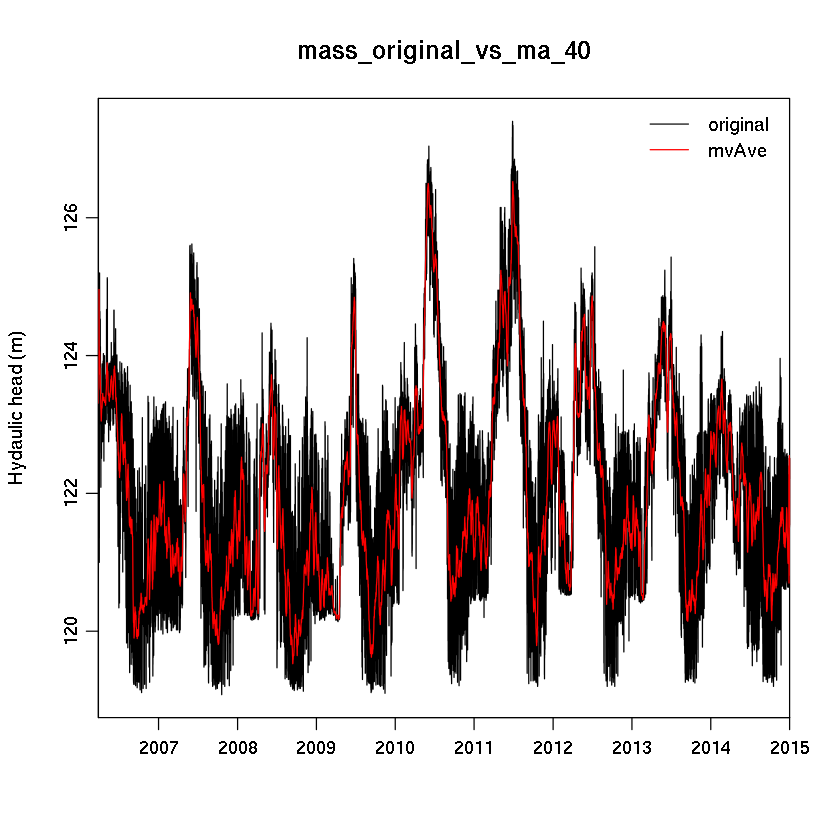

In [54]:
# for (islice in 1:nslice) {
  islice = 1
#   jpeg(paste("figures/mass_original_vs_mvAve_", slice.list[islice], "_",nwindows,"h.jpg", sep=''),width=8,height=5,units='in', res = 300)


  plot(original_time_series, original_mass_level[islice, 1:length(original_time_series)], 
       type = "l", col= "black", axes = F, 
       xlab=NA,ylab="Hydaulic head (m)",
       xaxs = 'i'
      )
  box()

  axis(2,at=seq(118,128,2),mgp=c(5,0.7,0),cex.axis=1)

  axis.POSIXct(1,at=seq(as.Date("2007-01-01",tz="GMT"),
                        to=as.Date("2016-01-01",tz="GMT"),by="year"),
               format="%Y",mgp=c(5,0.7,0))
  

  lines(new_time_series, new.mass.level[islice,], col= "red")


  legend("topright",legend = c("original","mvAve"), col = c("black", "red"), lty = c("solid", "solid"), bty = "n")
  title(paste("mass_original_vs_ma_", slice.list[islice], sep=''))
#   dev.off()
# }

## calculate gradient

In [55]:
mass.level = new.mass.level
simu.time = ma_time
ntime = length(simu.time)

In [57]:
##------------------------calculate gradient--------------------------------##
# mass.gradient = array(NA,c(nslice,(ntime+1)))
mass.gradient.x = array(NA,c(nslice,ntime))
mass.gradient.y = array(NA,c(nslice,ntime))
rownames(mass.gradient.y) = slice.list
rownames(mass.gradient.x) = slice.list

for (islice in 1:(nslice-1)) #from top to bottom. 
{
  distance = sqrt((mass.coord[islice+1,
                              "northing"]-mass.coord[islice,"northing"])^2 +
                    (mass.coord[islice+1,"easting"]-mass.coord[islice,"easting"])^2)
  ## calculate grad based on x-direction
  mass.gradient.x[islice,] = (mass.level[islice+1,]-mass.level[islice,]
  )/distance*(mass.coord[islice+1,"easting"]-mass.coord[islice,"easting"])/distance   
  
  ## calculate grad based on y-direction    
  mass.gradient.y[islice,] = (mass.level[islice+1,]-mass.level[islice,]
  )/distance*(mass.coord[islice+1,"northing"]-mass.coord[islice,"northing"])/distance 
}


## output gradient, datum to file

In [58]:
# gradient_314 is calcuated based on 315 and 314
for (islice in 1:(nslice-1))
{ 
    print(islice)
    Gradients = cbind(simu.time,
                      mass.gradient.x[islice,],
                      mass.gradient.y[islice,],
                      rep(0,(ntime)))
    
    DatumH = cbind(simu.time,
                   rep(mass.coord[islice,"easting"],ntime),
                   rep(mass.coord[islice,"northing"],ntime),                                      
                   mass.level[islice,])

    write.table(DatumH, file=paste(fname_DatumH, slice.list[islice],'.txt',sep=""),col.names=FALSE,row.names=FALSE) 
    write.table(Gradients, file=paste(fname_Gradients, slice.list[islice],".txt",sep=''),col.names=FALSE,row.names=FALSE)
    
    
}


[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13
[1] 14
[1] 15
[1] 16
[1] 17
[1] 18
[1] 19
[1] 20
[1] 21
[1] 22
[1] 23
[1] 24
[1] 25
[1] 26
[1] 27
[1] 28
[1] 29
[1] 30
[1] 31
[1] 32
[1] 33
[1] 34
[1] 35
[1] 36
[1] 37
[1] 38
[1] 39
[1] 40
[1] 41
[1] 42
[1] 43
[1] 44
[1] 45
[1] 46
[1] 47
[1] 48
[1] 49
[1] 50
[1] 51
[1] 52
[1] 53
[1] 54
[1] 55
[1] 56
[1] 57
[1] 58
[1] 59
[1] 60
[1] 61
[1] 62
[1] 63
[1] 64
[1] 65
[1] 66
[1] 67
[1] 68
[1] 69
[1] 70
[1] 71
[1] 72
[1] 73
[1] 74
[1] 75
[1] 76
[1] 77
[1] 78
[1] 79
[1] 80
[1] 81
[1] 82
[1] 83
[1] 84
[1] 85
[1] 86
[1] 87
[1] 88
[1] 89
[1] 90
[1] 91
[1] 92
[1] 93
[1] 94
[1] 95
[1] 96
[1] 97
[1] 98
[1] 99
[1] 100
[1] 101
[1] 102
[1] 103
[1] 104
[1] 105
[1] 106
[1] 107
[1] 108
[1] 109
[1] 110
[1] 111
[1] 112
[1] 113
[1] 114
[1] 115
[1] 116
[1] 117
[1] 118
[1] 119
[1] 120
[1] 121
[1] 122
[1] 123
[1] 124
[1] 125
[1] 126
[1] 127
[1] 128
[1] 129
[1] 130
[1] 131
[1] 132
[1] 133
[1] 134
[1] 135
[1] 136
[1] 137
[1] 138
[1] 